# DeepFool

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
import IPython.display as ipd

## Helper functions

In [4]:
def preprocess(image):
    '''
    args:
        image: 변환하고자 하는 이미지
    return:
        tf.float32 로 형변환
        픽셀값 정규화
        그림 크기 정규화
        axis = 0 에 차원 하나 추가해줌 (prediction 시키려면 4차원 데이터를 넣어주어야 함)
    '''
    
    image = tf.cast(image, tf.float32) # 이미지 형변환
    image = image/255 # 정규화
    image = tf.image.resize(image, (224, 224)) # 그림 크기 맞춰줌
    image = image[None, ...] # expand_dim 에 axis=0 한거랑 같음
    return image

def unresize(image, size):
    return tf.image.resize(image,size)

def get_imagenet_label(probs):
    '''
    args:
        이미지 prediction 한 결과 (1000개 클래스 각각에 대해 해당 클래스에 속할 확률로 된 벡터)
    return:
        가장 확률 높은 클래스에 대하여 ???, 클래스 이름, confidence
    '''
    return decode_predictions(probs,top=1)[0][0]

def display_images(image, description, size):
    '''
    시각화
    '''
    _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
    image = unresize(image, size)
    plt.figure()
    plt.imshow(image[0])
    plt.title(f'{format(description)} \n {label} : {confidence*100:.2f}% Confidence')
    plt.show()

## ImageNet 으로 사전학습 한 MobileNetV2 모델 불러오기

In [5]:
class Model(tf.keras.models.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.pretrained_model = tf.keras.applications.MobileNetV2(
            include_top=True,weights='imagenet', classifier_activation=None)
        
    def call(self, inputs, training=False, logits=False):
        x = self.pretrained_model(inputs, training=training)
        if logits:
            return tf.nn.softmax(x), x #softmax, logits
        else:
            return tf.nn.softmax(x) # only softmax

pretrained_model = Model()
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

## Original Image

짱절미 사진 온라인에서 불러오기

In [6]:
class_dict = dict()

for i in range(0,1000,4):
    for j in range(4):
        pseudo_probs = np.zeros((1,1000))
        pseudo_probs[0][i+j] = 1.
        name = decode_predictions(pseudo_probs,top=1)[0][0][1]
#         print(i,name,end='\t')
        k = i+j
        class_dict[k] = name
#     print()

In [7]:
image_path = tf.keras.utils.get_file('JjangJeolMi.jpg', 'https://img.animalplanet.co.kr/news/2019/08/16/700/dkru0l62e819mnj1tf91.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)
image_shape = image.shape

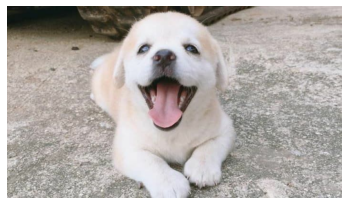

In [8]:
plt.imshow(image)
plt.axis('off')
plt.show()

In [9]:
image = preprocess(image)
image_probs = pretrained_model.predict(image)

In [10]:
np.argmax(image_probs)

208

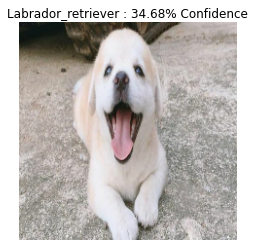

In [11]:
plt.figure()
plt.imshow(image[0])
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.axis('off')
plt.show()

## DeepFool 구현
* official implementation 참고 [링크](https://github.com/LTS4/DeepFool/blob/master/Python/deepfool.py)

In [12]:
def deep_fool(x, y, model, verbose=False):
    """
    args:
        a sample of input (x) and target (y)
    return:
        perturbation (not perturbed image!)
    """
    assert len(x) == len(y) == 1
    x = tf.cast(x, dtype=tf.float32)
    y = int(np.squeeze(y))
    r_total = np.zeros(x.shape)

    max_k = 0

    for itr in range(100): # max iteration = 50
        ipd.clear_output(wait=True)
        print('iteration', itr)
        
        pert = np.inf
        with tf.GradientTape() as t:
            t.watch(x)
            _, y_pred_orig = model(x, logits=True)
            target = y_pred_orig[0][y]
            
        if np.argmax(y_pred_orig) != y:
            if verbose:
                print('Already wrong answer!')
            break
        else:
            y_pred = model(x + r_total)
            if np.argmax(y_pred[0]) != y:
                if verbose:
                    print("Attack success!")
                break
        
        grads_orig = t.gradient(target, x)
        
        with tf.GradientTape(persistent=True) as t:
            t.watch(x)
            _, y_pred_k = model(x, logits=True)
            y_pred_list = []
            for i in range(y_pred_k.shape[-1]):
                y_pred_list.append(y_pred_k[0][i])
            
        for k in tqdm(range(y_pred_k.shape[-1])): # num_classes
            if k == y:
                continue
            cur_grads = t.gradient(y_pred_list[k], x)
            w_k = cur_grads - grads_orig
            f_k = y_pred_k[0][k] - y_pred_orig[0][y]
            
            pert_k = abs(f_k)/tf.norm(tf.reshape(w_k, [-1]))
            if pert_k < pert:
                pert = pert_k
                w = w_k
                max_k = k
        r_i = (pert+1e-4) * w / tf.norm(w)
        r_total = r_total + r_i
        r_total *= (1.02)
    if verbose:
        print("itr", itr)
        print('max k', max_k)
    return r_total

In [13]:
r = deep_fool(image, [np.argmax(image_probs)], pretrained_model, verbose=True)

iteration 1
Attack success!
itr 1
max k 216


In [14]:
image_probs = pretrained_model.predict(image+r)

In [15]:
np.argmax(image_probs)

216

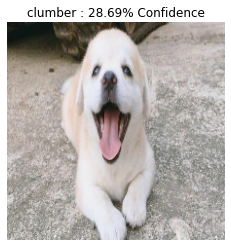

In [16]:
plt.figure()
plt.imshow(np.squeeze(image+r))
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.axis('off')
plt.show()

라브라도 리트리버가 클럼버 스파니엘 되어버림